## Astro 304 (Spring 2016) "Galaxies"

### Homework 5 (35 points + 20 extra credit points)

### Due, Friday, May 26, 9pm

### Exploring processes affecting galaxy formation and building a galaxy formation model

Please compare your results from HW 4 with mine. If you have an error in your $M_*-M$ relation or model calculation results, please identify and correct it. For exercise 2, you can also use the $z=0$ $M_\star-M_{\rm halo}$ relation generated in my hw04_solutions, which is saved in the file <tt>data/ms_mvir_z0.dat</tt>, which you can read as follows:

In [ ]:
# load the z=0 M*-Mvir relation derived from AM above
#MvirAM and MsAM are both in Msun (no h), and were computed for h=0.7
MvirAM, MsAM = np.loadtxt(data_home_dir()+'ms_mvir_z0.dat', usecols=(0,1), unpack=True)


<b>1. Size model in the galaxy formation model and comparison with observations. (20 points).</b> As discussed in S 2.4.4 of the <a href="http://astro.uchicago.edu/~andrey/classes/a304s17/main.pdf">notes</a>, in the classic models of disk galaxy formation disk sizes are set by the specific angular momentum of gas, so that $r_{1/2}\propto \lambda R_{200}$, where $\lambda$ is dimensionless spin parameter characterizing specific angular momentum (Fall & Efstathiou 1980; Mo, Mao & White 1998 - hereafter MMW), which is defined as $\lambda=j/(V_{200}R_{200})$, where $j$ is specific angular momentum (AM per unit mass) of baryons when they accrete onto halo, $V_{200}=\sqrt{GM_{200}/R_{200}}$ is halo circular velocity at $R_{200}$,  and $R_{200}$ is the radius enclosing density contrast equal $200\rho_{\rm crit}(z)$, where $\rho_{\rm crit}(z)=3H^2(z)/(8\pi G)$ is the critical density at redshift $z$: 
$$R_{200}=[3M_{200}/(4\pi G 200\rho_{\rm cr})]^{1/3}=162.63h^{-1}\, {\rm kpc}(M_{200}/10^{12}h^{-1}\ M_{\odot})^{1/3} E(z)^{-1}.$$
It can be computed from the halo mass using the colossus function <a href="http://bdiemer.bitbucket.org/halo_mass_so.html">halo.mass_so.M_to_R</a> as shown in code example below. 

<b>(a) - 10 points.</b> Implement the model for $r_{50}$ from Mo, Mao and White (1998) given by equation 2.50 in the notes: $$r_{50}=1.678R_d=1.187(j_d/m_d)f_c^{-1/2}f_R\lambda R_{200},$$
a routine with the model for galaxy size in the galaxy model you started exploring in HW 4.

Here $r_{50}$ is galaxy half mass radius, $R_d$ is disk exponential scale length, $R_{200}$ is the radius enclosing density contrast of 200 relative to the critical density at the redshift of interest, $c=c_{200}$ is concentration of halo profile (see below for how to compute it with colossus), $j_d$ and $m_d$ are fractions of baryon angular momentum and mass budget within halo in the central disk, $f_c$ is a function of halo concentration (see eq. 23 in MMW98 and below for the exact expression), and $f_R\approx 1$  is a function that can be used to take into account baryonic contraction of halo in response to halo formation  (see S 2.3 of MMW98). Assuming $j_d/m_d=1$, $f_R=1$, and compute $f_c$ factor using concentration model within colossus a

Essentially, for each epoch the model knows mass of the halo that is hosting the model galaxy (<tt>self.Mh</tt>). Use the host mass and colossus <tt>M_to_R</tt> conversion routine as above to get radius. Assume constant spin parameter of $\lambda=0.045$ (this is the median of the log-normal distribution of halo spins), $j_d/m_d=1$, $f_R=1$, and compute $f_c$ factor using concentration model within colossus, as shown in the example below.

Test the routine by plotting $r_{50}$ vs $R_{200}$ at a few redshifts. 

<b>(b) (10 points)</b> Run the model for a series of halo masses as was done previously and construct ${r50}-M_\star$ relation predicted. Use the Meert et al. (2015) SDSS data set we've been using before to plot the distribution of galaxies in the $r_{50}-M_\star$ plane and construct the median $r_{50}$ at a given $M_\star$ and plot it as a function of $M_\star$. Compare the prediction of the model to the relation exhibited by the data. Comment on the similarities or discrepancies that you notice. 

In [2]:
# setup notebook for inline figures
%matplotlib inline
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

In [5]:
#
# example how to convert halo masses using colossus
# the halo mass in the galaxy_model code is defined using "virial" density contrast
# relative to the mean density of the universe. We need to convert it to mass and radius for density contrast of 200
# relative to the *critical* density
#
import numpy as np
from colossus.halo.concentration import concentration
from colossus.cosmology import cosmology
from colossus.halo.mass_so import M_to_R
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

z = 0.0;
Mvir = 1.e12; # in /h Msun
 
cvir = concentration(Mvir, 'vir', z, model='diemer15')
M200c, R200c, c200c = changeMassDefinition(Mvir, cvir, z, 'vir', '200c')
print "M200c = %.2e (/h Msun); R200c = %.3f (/h kpc); c200c = %.3f"%(M200c, R200c, c200c)

# M_to_R takes mass in /h Msun and outputs R in /h kpc
print "%.2f"%(M_to_R(M200c, z, '200c')/cosmo.h)


M200c = 8.40e+11 (/h Msun); R200c = 153.475 (/h kpc); c200c = 7.627
219.25


In [6]:
Mvir = 1.e12; z=1.
c = concentration(Mvir, 'vir', z, model='diemer15')
# see eq. 23 in Mo, Mao & White 1998
c=10
fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
print "c=%.3f, fc=%.3f"%(c, fc)
jmlam = 0.045 # (j_d/m_d)*lambda
md = 0.05
fR = (jmlam/0.1)**(-0.06+2.71*md+0.0047/jmlam)*(1.-3.*md+5.2*md**2)*(1.-0.019*c+2.5e-4*c*c+0.52/c)
eta = 1.187/np.sqrt(fc)*jmlam*fR
print "fR=%.3f"%fR
print "eta=%.3f"%eta

c=10.000, fc=1.254
fR=0.663
eta=0.032


<b>2. Simple model of galactic wind. (15 points)</b> Energy and momentum injection by supernovae feedback is thought to drive powerful winds from galaxies. The mass outflow rate scales as $dM_{\rm g}/dt=\epsilon_{\rm out} dM_*/dt$, where $\epsilon_{\rm out}$ is called the <i>mass loading factor</i> and can be constant or varying with galaxy parameters (see (b) below). <a href="http://adsabs.harvard.edu/abs/2012ApJ...753...16K">Krumholz & Dekel (2012)</a>  simply assume that it is constant: $\epsilon_{\rm out}=1$ (see their eq. 1 and Table 1). This is broadly consistent with what we know about winds of observed $L\sim L_*$ galaxies, although there are both observational and theoretical indications that $\epsilon_{\rm out}$ likely depends on galaxy stellar mass. 

(a) Implement such constant $\epsilon_{\rm out}$ wind model and re-run galaxy evolution calculation for $M_*-M$ relation for a couple of values of $\epsilon_{\rm out}$. How does inclusion of outflow in this way affect the results? How does the predicted relation compare to the $M_\star-M_{\rm h}$ derived from the abundance matching in HW4? (5 points)

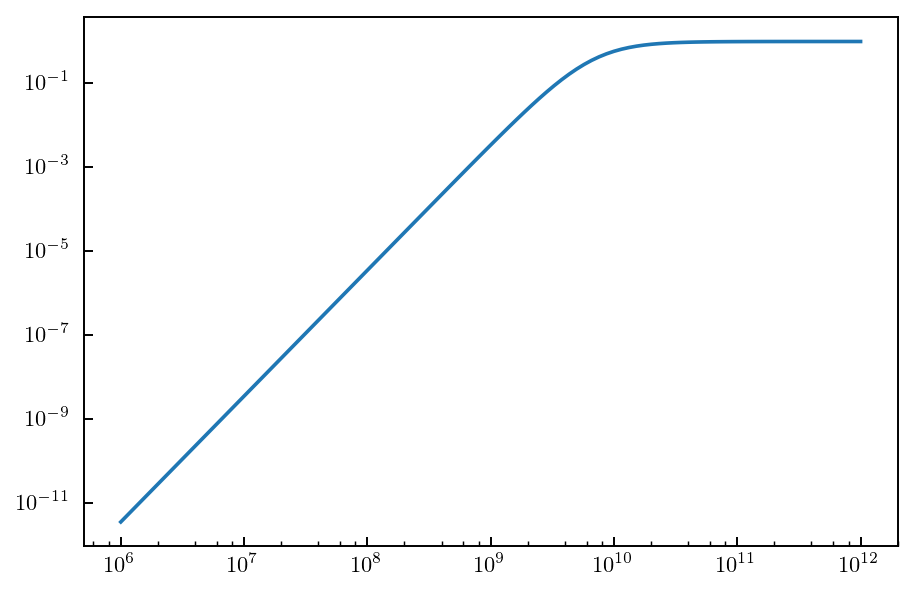

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...




evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(M

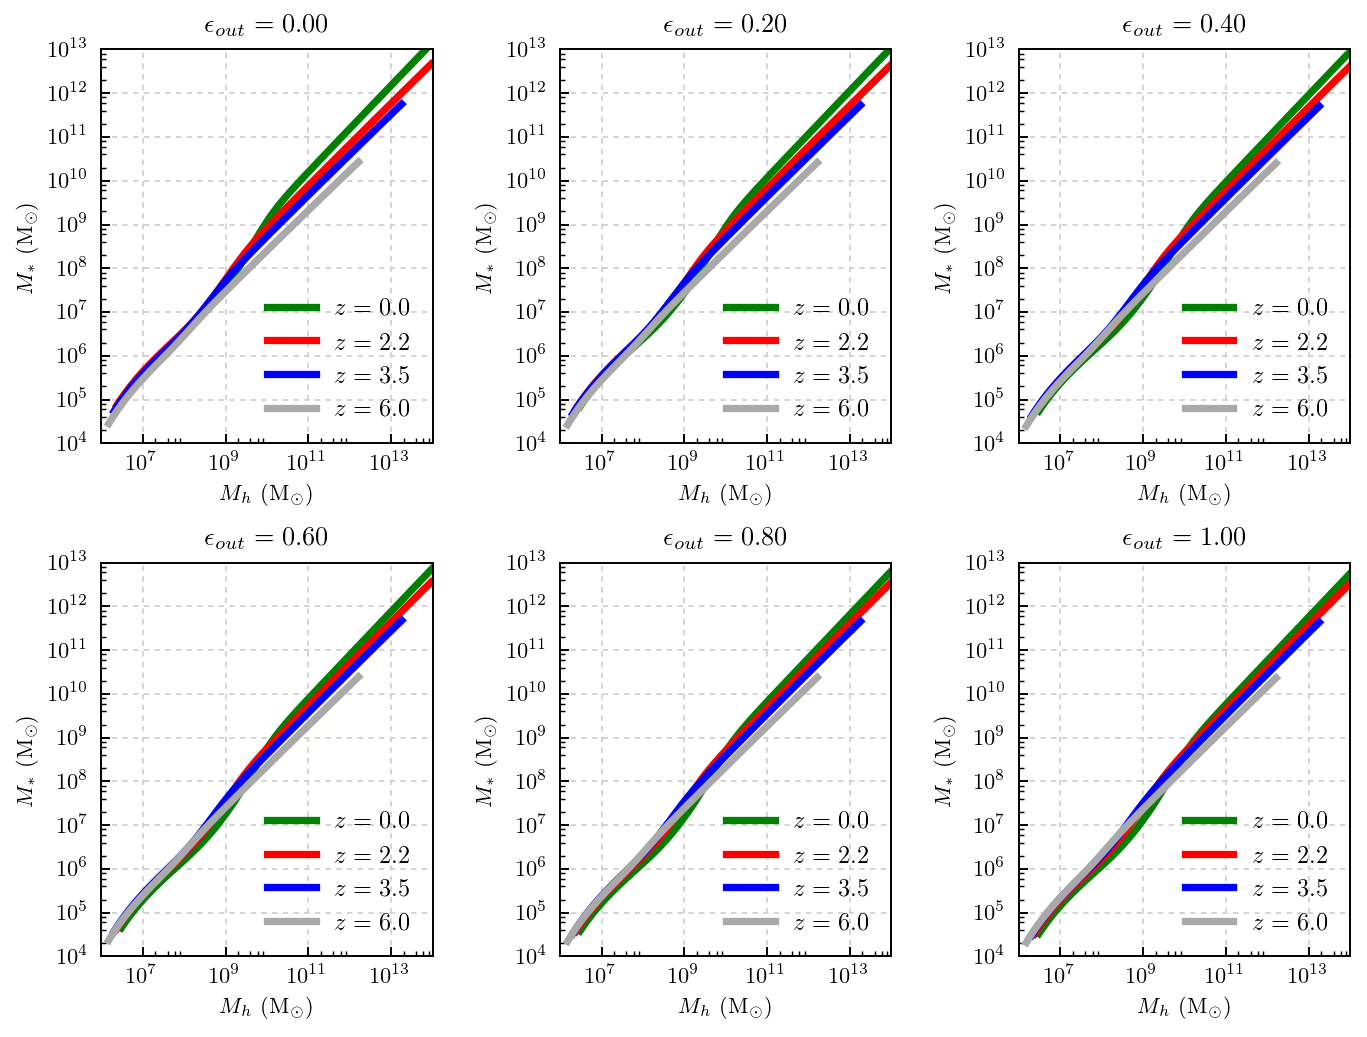

In [13]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology
from scipy.interpolate import interp2d
from scipy.integrate import odeint

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

sfrmodel = "gaslinear"  


def fg_in(Mh, z, h):
    '''
    Gnedin (2000) formalism. Hoeft et al. (2006); Okamoto, Gao, and Theuns (2008)
    calibration for reionization decreasing the baryon fraction in DM halos.
    '''
    alpha = 2.
    if z < 9.:
        Mc = 6.e9*np.exp(-0.63*z)/h
    if z > 9.:
        Mc = 3.e5/h
    fb = (1. + (2.**((alpha/3.)) - 1.)*(Mh/Mc)**(-alpha))**(-3./alpha)
    if np.any(fb <= 1e-30) or np.any(np.isnan(fb)):
        if type(fb) == float:
            fb = 1e-30
        if type(fb) == np.ndarray:
            fb[fb <= 1e-30] = 1e-30
            fb[fb == np.nan] = 1e-30
    return fb

mtest = np.logspace(6,12,100)
plt.plot(mtest, fg_in(mtest, 0., 0.7))
plt.xscale('log')
plt.yscale('log')
plt.show()


f, axs = plt.subplots(2, 3, figsize = (8,6))
plot_pretty()
epsarr = np.linspace(0., 1., 6)
for eps, ax in zip(epsarr, axs.flatten()):
    class local_gal(gm.model_galaxy):
        '''
        Modification of base galaxy model to account for reionization heating of
        baryons suppressing accretion in small DM halos.
        '''
        def Mg_in(self, t):
            '''
            hi I am here.
            '''
            fg = fg_in(self.Mh, self.z, self.cosmo.h)
            dummy = self.fbuni*self.eps_in(t)*fg*self.dMhdt(self.Mh,t)
            return dummy
        def Ms_in(self, t):
            '''
            Accreted stellar mass as fraction of accreted DM mass. Was originally set to
            be the remaining fraction of baryonic mass not accounted for in Mg_in. This
            was determined to be highly unphysical with the reionization correction
            made to fb_in. If gas accretion rate goes to 0, this does *not* imply that
            stellar mass accretion rate must approach (f_b,uni)*dM_h/dt. Baryonic accretion
            should instead go to 0 along with the halting of gas accretion.
            '''
            fg = 1.0
            dummy = self.fbuni*(1.0 - fg)*self.dMhdt(self.Mh,t)
            return dummy

        def eps_out(self):
            return eps

    from scipy.interpolate import interp2d

    # initial metallicity
    Z_IGM = 2.e-5

    # grid of redshifts and halo masses
    Nz = 41; Nm = 100
    zg = np.linspace(30., 0., Nz)
    lzg1 = np.log10(1.0+zg)
    t_output = cosmo.age(zg)

    lMh = np.linspace(5.0, 8., Nm)
    Mh  = np.power(10, lMh)

    # arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
    Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
    Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
    #evolve a grid of halo masses
    for j, Mhd in enumerate(Mh):
        if not j%5:
            print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
        # instantiate a model galaxy with a given halo mass at the initial time
        g = local_gal(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
        # initial values of masses
        y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
        # solve the system of ODEs
        Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
        Mout = Mout/g.cosmo.h
        # split Mout into arrays for specific masses with more intuitive names for convenience
        Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
        Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
    # 
    # prepare 2D splines for interpolation
    #
    Mmin = 1.e-10 # prevent zeros in case no SF occurred
    lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
    lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
    lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
    lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

    #
    # plot
    #

    ax.set_xlabel(r'$M_h\ \rm (M_\odot)$')
    ax.set_ylabel(r'$M_{*}\ \rm (M_\odot)$')
    ax.set_xlim(1.e6,1.e14)
    ax.set_ylim(1.e4,1.e13)
    ax.set_xscale('log')
    ax.set_yscale('log')

    z_plot = np.array([0., 2.2, 3.5, 6.0])
    # colors a la Feldmann for easier comparison
    zcolors = ['green', 'red', 'blue', 'darkgray']
    for i, zplot in enumerate(z_plot):
        Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
        Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
        # take care of numerical errors when calculating Ms for high Mh
        for j, e in enumerate(Msz):
            stop = -1
            if j > 0:
                if e <= Msz[j - 1]:
                    print('{0} < {1}'.format(e, Msz[j-1]))
                    stop = np.where(Msz == e)[0]
                    print(stop)
                    break
        Msz = Msz[:stop]
        Mhz = Mhz[:stop]
        print('')
        ax.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

    ax.legend(frameon=False,loc='lower right', fontsize=10)
    ax.grid(linestyle='dotted', c='lightgray')
    ax.set_title(r'\( \epsilon_{{out}} = {0:0.2f} \)'.format(eps))

f.tight_layout()
f.show()

With increasing contant $\epsilon_{out}$, the $M_*-M_h$ relation begins to converge at all redshifts for high mass. This makes sense as an $\epsilon_{out} = 0.00 $ would allow for uninterrupted star formation throughout a galaxy's evolution. Seeing the halo mas stellar mass relation converge for increasing $\epsilon_{out}$ at relatively low redshifts $z < 2$ suggests star formation begins to be stunted at $z ~ 2$ when incorporating even a crude outflow model; consistent with observations (or tuned to match observations?).

(b) Recent simulations of galaxy formation have started to calibrate wind models of the kind discussed in (a) above. In particular, <a href="http://adsabs.harvard.edu/abs/2015MNRAS.454.2691M">Muratov et al. (2015)</a> report that the loading factor has simple scaling with stellar mass in their simulations: $\epsilon_{\rm out}=3.6M_{*,10}^{-0.35}$ where $M_{*,10}$ is galaxy current stellar mass in units of $10^{10}\ M_\odot$ (see their Fig. 6 and eq. 8). Implement such model and discuss the differences from the model implemented in (a). What is the overall effect of wind outflows on $M_*-M$ relation? How does the predicted relation compare to the $M_\star-M_{\rm h}$ derived from the abundance matching in HW4? (5 points) Interpret the shape of this relation using the arguments presented in the notebook <tt>ex10_galaxy_formation_model.ipynb</tt>(5 points)

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...






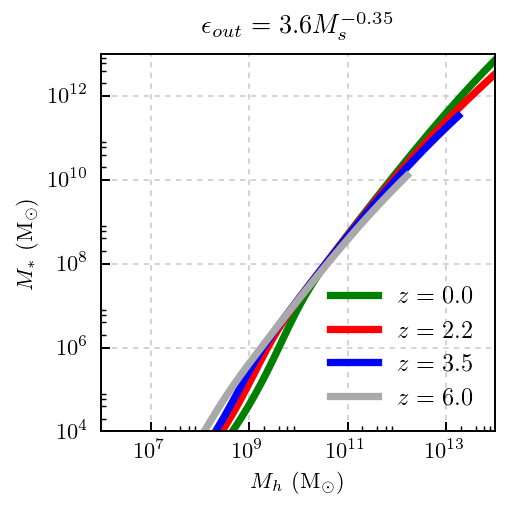

In [17]:

class local_gal(gm.model_galaxy):
    '''
    Modification of base galaxy model to account for reionization heating of
    baryons suppressing accretion in small DM halos.
    '''
    def Mg_in(self, t):
        '''
        hi I am here.
        '''
        fg = fg_in(self.Mh, self.z, self.cosmo.h)
        dummy = self.fbuni*self.eps_in(t)*fg*self.dMhdt(self.Mh,t)
        return dummy
    def Ms_in(self, t):
        '''
        Accreted stellar mass as fraction of accreted DM mass. Was originally set to
        be the remaining fraction of baryonic mass not accounted for in Mg_in. This
        was determined to be highly unphysical with the reionization correction
        made to fb_in. If gas accretion rate goes to 0, this does *not* imply that
        stellar mass accretion rate must approach (f_b,uni)*dM_h/dt. Baryonic accretion
        should instead go to 0 along with the halting of gas accretion.
        '''
        fg = 1.0
        dummy = self.fbuni*(1.0 - fg)*self.dMhdt(self.Mh,t)
        return dummy

    def eps_out(self):
        if self.Ms <= 0.:
            Ms = 1e-9
        else:
            Ms = self.Ms
        eps = 3.6*(Ms/1e10)**(-0.35)
        return eps

from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)

lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = local_gal(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

#
# plot
#

f, ax = plt.subplots(figsize = (3,3))
plot_pretty()
ax.set_xlabel(r'$M_h\ \rm (M_\odot)$')
ax.set_ylabel(r'$M_{*}\ \rm (M_\odot)$')
ax.set_xlim(1.e6,1.e14)
ax.set_ylim(1.e4,1.e13)
ax.set_xscale('log')
ax.set_yscale('log')

z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    # take care of numerical errors when calculating Ms for high Mh
    for j, e in enumerate(Msz):
        stop = -1
        if j > 0:
            if e <= Msz[j - 1]:
                print('{0} < {1}'.format(e, Msz[j-1]))
                stop = np.where(Msz == e)[0]
                print(stop)
                break
    Msz = Msz[:stop]
    Mhz = Mhz[:stop]
    print('')
    ax.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

ax.legend(frameon=False,loc='lower right', fontsize=10)
ax.grid(linestyle='dotted', c='lightgray')
ax.set_title(r'\( \epsilon_{{out}} = 3.6M_s^{{-0.35}} \)')

f.tight_layout()
f.show()

Incorporating this gaseous outflow model successfully reproduces (qualitatively) the bend in the $M_*-M_h$ relation. It did not effect the high mass end much, if at all, primarily causing the turnover at the low end, implying stellar feedback affects low mass galaxy SFR more than high mass galaxy SFRs.

Looking at the relations from the previous HW, the qualitative inversion of the curves at the elbow was only seen for $z \gtrsim 2$. For the low mass end, all z < 2 curves fell roughly on top of one another. This implies we are over-suppressing our SFRs?    

The "elbow" mass is also an order of magnitude less than seen in the previous HW.

Looking at the high mass end, we are clearly not sufficiently suppressing our high mass halo SFR. This is the starkest contrast with the previous homework. First, obvious is that the slope is much higher than the observed slope. Second, the $M_*-M_h$ relation for $z \lesssim 2$ were *below* those for $ z > 2 $. This was a clear sign of suppressed star formation at late times in high mass galaxies, which we fail to reproduce here. So it's something besides stellar feedback that leads to this halting of star formation in high mass galaxies.

<b>3. extra credit (20 points)</b> In the <tt><a href="https://github.com/a-kravtsov/a304s17/blob/master/ex09_cooling_heating.ipynb">ex09_cooling_heating.ipynb</tt> notebook I showed how to compute cooling time at the virial radius for halos of different mass at different redshifts. I also showed how a crude model from Krumholz & Dekel (2012) can be used to define halo mass above which the hot halo forms and accretion of gas from the halo onto galaxies is suppressed.  Implement an alternative model for <tt>Mhot</tt> but via Mgas/tcool. 

Namely, introduce a separate variable <tt>Mghot</tt> and arrange to solve a differential equation for it. All of the newly accreted gas should be deposited into <tt>Mghot</tt> and gas from this halo reservoir cools onto galaxy at a rate <tt>Mghot/tcool</tt>, where <tt>tcool</tt> is the cooling time evaluated at the halo virial radius, as illustrated in ex09. Predict the $M_\star-M_{\rm h}$ relation evolution using this model and compare with the relation derived from the abundance matching. Comment on the effect of the cooling time on the stellar masses of galaxies. Compare qualitatively to the crude model of this process used in KD12. 